In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#récupérer les tweets nettoyés
clean_data= '/content/drive/MyDrive/Colab Notebooks/clean_1milliontweet.txt'
with open(clean_data, "r") as file:
    lines = file.readlines()
    
clean_full = [line.split() for line in lines]

In [ ]:
# transformer en dataframe
data = pd.DataFrame(lines, columns = ['tweet'])

In [ ]:
print(len(data['tweet']))

658132


In [ ]:
print(data.tweet)

0                                                        \n
1                                                        \n
2                                                        \n
3                                                        \n
4                                                        \n
                                ...                        
658127               自動 mademoiselle hortense bras gauche\n
658128              自然  by 𝘃𝗼𝗴𝘂𝗲𝗽𝗹𝗲𝘂𝗿𝘀    𝗻𝗼𝘁𝗲𝘀  oƒ  𝖮𝗇𝗅...
658129    花見  ৶  𖧧       𝖮𝗅𝗂𝗏𝗂𝖺𝗌 𝖲𝗉𝖺𝖼𝖾 𖤐 new updat  vía ...
658130                   金玉 testicule bijou joyau balle  \n
658131                               魈空 xiaoaether zombie\n
Name: tweet, Length: 658132, dtype: object


In [ ]:
!pip install gensim==4.0

In [ ]:
from gensim.models import KeyedVectors

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
# récupérer les embeddings entrainés sur nos données
w2v = KeyedVectors.load('/content/drive/MyDrive/Colab Notebooks/w2vec_model_d300_1M')

In [ ]:
import numpy as np

In [ ]:
#encode un message
def encode(msg):
    return np.mean([w2v[word] for word in msg if word in w2v] or [np.zeros(300)], axis = 0)

In [ ]:
w2v.similar_by_word("sale")

[('sal', 0.6782066822052002),
 ('pvte', 0.629138708114624),
 ('mèrde', 0.6162537336349487),
 ('pute', 0.6096962094306946),
 ('pte', 0.6044666767120361),
 ('clochard', 0.6014346480369568),
 ('slp', 0.6004031896591187),
 ('crasseux', 0.5957321524620056),
 ('puent', 0.5908592939376831),
 ('daronn', 0.5900101661682129)]

In [ ]:
%%time
#encodage des données pour créer le jeu de données
dataset_encoded = np.array([encode(msg) for msg in clean_full])

CPU times: user 25.9 s, sys: 1.64 s, total: 27.6 s
Wall time: 27.4 s


In [ ]:
%%time
from sklearn.ensemble import IsolationForest
# definir le modèle ainsi que ses paramètres
clf=IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
# Entrainer le modèle
clf.fit(dataset_encoded)

CPU times: user 7min 30s, sys: 9.22 s, total: 7min 39s
Wall time: 4min 2s


In [ ]:
%%time
# faire des prédictions sur nos données
pred = clf.predict(dataset_encoded)

CPU times: user 1min 59s, sys: 7.38 s, total: 2min 6s
Wall time: 2min 8s


In [ ]:
# rajouter une colonne dans le dataframe
data['pred']= pred

In [ ]:
print(data.head(20))

                                                tweet  pred
0                                                  \n     1
1                                                  \n     1
2                                                  \n     1
3                                                  \n     1
4                                                  \n     1
5    ー kun   instagram kun poster compte  nct   nc...     1
6         ー 𝐋𝐨𝐮𝐢𝐬𝐨𝐢𝐱 𝐋𝐞𝐯𝐞𝐢𝐥𝐥𝐞𝐮𝐫𝐬 𝐋𝐞𝐠𝐚𝐜𝐲 ー         ...     1
7    ー sungchan   snsmc sungchan inkigayo  nctsmto...     1
8    ー taeyong   instagram taeyong poster compte  ...     1
9    ー ten   sn ten couverture magazine monsieur f...     1
10   ー ten winwin   snsten winwin monsieur figaro ...     1
11   updat wevers commentaire hwanwoongcomme sembl...     1
12     dollar dollar dollar dollar gros chèque paie\n    -1
13      dollar dollar dollar dollar tf ess tribunal\n    -1
14                 dollar dollar dollar  market cap\n    -1
15   dollar bonus change  dollar superma

In [ ]:
#localiser les outliers dans le dataframe
outliers=data.loc[data['pred']==-1]
outlier_index=list(outliers.index)
print(data['pred'].value_counts())

 1    618400
-1     39732
Name: pred, dtype: int64


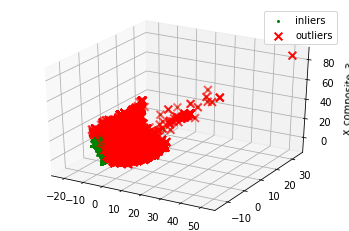

CPU times: user 43.5 s, sys: 8.28 s, total: 51.8 s
Wall time: 38.2 s


In [ ]:
# Visulaliser les outliers 3 dimensions
%%time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(dataset_encoded)
X_reduce = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

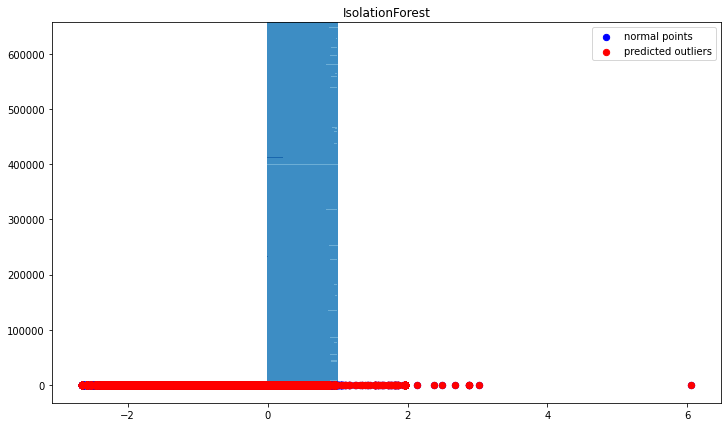

CPU times: user 30.8 s, sys: 4.34 s, total: 35.2 s
Wall time: 29.7 s


In [ ]:
# Visulaliser les outliers 2 dimensions
%%time
pca = PCA(2)
pca.fit(dataset_encoded)


res=pd.DataFrame(pca.transform(dataset_encoded))

Z = np.array(res)
figsize=(12, 7)
plt.figure(figsize=figsize)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(res[0], res[1], c='blue',
                 s=40,label="normal points")

b1 = plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',
                 s=40,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [ ]:
print(outliers.head)

<bound method NDFrame.head of                                                     tweet  pred
12         dollar dollar dollar dollar gros chèque paie\n    -1
13          dollar dollar dollar dollar tf ess tribunal\n    -1
14                     dollar dollar dollar  market cap\n    -1
15       dollar bonus change  dollar supermariomaker n...    -1
16                                        dollar  range\n    -1
...                                                   ...   ...
657976     일탈 섹트 조건만남 조건 ㅈㄱ 광주조건 광주만남 섹트 일탈 전남 광주 jcbdo\n    -1
657984   일탈 섹트 조건만남 조건 ㅈㄱ 광주조건 광주만남 섹트 일탈 전남 광주 mettgvo\n    -1
657985  일탈 섹트 조건만남 조건 ㅈㄱ 광주조건 광주만남 섹트 일탈 전남 광주 mdjmyfp...    -1
657988     일탈 섹트 조건만남 조건 ㅈㄱ 광주조건 광주만남 섹트 일탈 전남 광주 oyhlu\n    -1
658067                                ㅡjikook one tweet\n    -1

[39732 rows x 2 columns]>


On remarque que les outliers sont des tweets  contenant les mots dollars , des mots en coréen

In [ ]:
with open("outliers.txt", 'a') as f:
    dfAsString = outliers.to_string(header=False, index=False)
    f.write(dfAsString)